In [1]:
USER_PROFILE_ID_TO_INTEREST = {
    "10006": "Long-term_interest_news",
    "10024": "Long-term_interest_education",
    "10031": "Long-term_interest_automobile",
    "10048": "Long-term_interest_real_estate",
    "10052": "Long-term_interest_IT",
    "10057": "Long-term_interest_electronic_game",
    "10059": "Long-term_interest_fashion",
    "10063": "Long-term_interest_entertainment",
    "10067": "Long-term_interest_luxury",
    "10074": "Long-term_interest_home_and_lifestyle",
    "10075": "Long-term_interest_health",
    "10076": "Long-term_interest_food",
    "10077": "Long-term_interest_divine",
    "10079": "Long-term_interest_motherhood_and_parenting",
    "10083": "Long-term_interest_sports",
    "10093": "Long-term_interest_travel_and_outdoors",
    "10102": "Long-term_interest_social",
    "10684": "In-market_3c_product",
    "11092": "In-market_appliances",
    "11278": "In-market_clothing_shoes_and_bags",
    "11379": "In-market_Beauty_and_Personal_Care",
    "11423": "In-market_household_and_home_improvement",
    "11512": "In-market_infant_and_mom_products",
    "11576": "In-market_sports_item",
    "11632": "In-market_outdoor",
    "11680": "In-market_health_care_products",
    "11724": "In-market_luxury",
    "11944": "In-market_real_estate",
    "13042": "In-market_automobile",
    "13403": "In-market_finance",
    "13496": "In-market_travel",
    "13678": "In-market_education",
    "13776": "In-market_service",
    "13800": "Long-term_interest_art_photography_and_design",
    "13866": "Long-term_interest_online_literature",
    "13874": "In-market_electronic_game",
    "14273": "Long-term_interest_3c",
    "16593": "In-market_book",
    "16617": "In-market_medicine",
    "16661": "In-market_food_and_drink",
    "16706": "Long-term_interest_culture",
    "16751": "Long-term_interest_sex",
    "10110": "Demographic_gender_male",
    "10111": "Demographic_gender_female"
}


def map_feature_names(feature_names):
    mapped = []
    for feat in feature_names:
        if feat.startswith("User_Profile_"):
            id_ = feat.split("_")[-1]
            readable = USER_PROFILE_ID_TO_INTEREST.get(id_, f"profile_{id_}")
            mapped.append(f"{readable}")
        else:
            mapped.append(feat)
    return mapped

In [2]:
import pandas as pd
import random

# Using LightGBM

# Import for 1458 ( Chinese vertical e-commerce )

In [3]:
df = pd.read_csv("processed_advertiser_1458.csv")

In [4]:
df.columns

Index(['hour', 'minute', 'day_of_the_week', 'is_weekend', 'part_of_the_day',
       'os_family', 'browser_family', 'device_type', 'ip_subnet_hash',
       'Region_ID', 'City_ID', 'Ad_Exchange', 'Domain_Cat',
       'Ad_Slot_ID_grouped', 'ad_slot_width', 'ad_slot_height',
       'ad_slot_ratio', 'ad_slot_area', 'ad_slot_visibility', 'Ad_Slot_Format',
       'Ad_Slot_Floor_Price', 'Creative_ID', 'User_Profile_IDs', 'Click'],
      dtype='object')

In [5]:
df['ad_slot_ratio'].mean()

5.812210274863468

In [6]:
df.head(1)

,hour,minute,day_of_the_week,is_weekend,part_of_the_day,os_family,browser_family,device_type,ip_subnet_hash,Region_ID,...,ad_slot_width,ad_slot_height,ad_slot_ratio,ad_slot_area,ad_slot_visibility,Ad_Slot_Format,Ad_Slot_Floor_Price,Creative_ID,User_Profile_IDs,Click
0,0,1,4,0,night,Windows,Internet Explorer,desktop,Other,94,...,160,600,0.266667,96000,2,0,5,cb7c76e7784031272e37af8e7e9b062c,NaN,0


In [7]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import joblib

categorical_columns = [
    'hour', 'day_of_the_week', 'is_weekend', 'part_of_the_day',
    'ip_subnet_hash', 'Domain_Cat',
    'os_family', 'browser_family', 'device_type', 'Region_ID',
    'City_ID', 'Ad_Exchange', 'Ad_Slot_ID_grouped', 'ad_slot_visibility',
    'Ad_Slot_Format', 'Creative_ID'
]


df['User_Profile_IDs'] = df['User_Profile_IDs'].fillna("")
df['User_Profile_IDs'] = df['User_Profile_IDs'].apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])

mlb = MultiLabelBinarizer()
user_profile_encoded = pd.DataFrame(
    mlb.fit_transform(df['User_Profile_IDs']),
    columns=[f"User_Profile_{id_}" for id_ in mlb.classes_],
    index=df.index
)

# Rename user_profile_encoded columns using the mapping
user_profile_encoded.rename(
    columns=lambda col: USER_PROFILE_ID_TO_INTEREST.get(col.split("_")[-1], col),
    inplace=True
)

# Step 2: Convert categorical columns to 'category' dtype for LightGBM
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Step 3: Combine original df (without User_Profile_IDs) with the multi-hot encoded user profile columns
df = pd.concat([df.drop('User_Profile_IDs', axis=1), user_profile_encoded], axis=1)

print(df.columns)
# Step 4: Define features and target
X = df.drop(['Click'], axis=1)
y = df['Click']

# Step 5: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Prepare LightGBM datasets
# LightGBM will infer categorical features automatically if their dtype is 'category'
categorical_feats = [col for col in categorical_columns if col in X.columns]

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feats)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train, categorical_feature=categorical_feats)


params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_test],  callbacks=[lgb.early_stopping(stopping_rounds=50)])
joblib.dump(model, "lightgbm_model_vertical_ecommerce.pkl")

y_pred_proba = model.predict(X_test)

Index(['hour', 'minute', 'day_of_the_week', 'is_weekend', 'part_of_the_day',
       'os_family', 'browser_family', 'device_type', 'ip_subnet_hash',
       'Region_ID', 'City_ID', 'Ad_Exchange', 'Domain_Cat',
       'Ad_Slot_ID_grouped', 'ad_slot_width', 'ad_slot_height',
       'ad_slot_ratio', 'ad_slot_area', 'ad_slot_visibility', 'Ad_Slot_Format',
       'Ad_Slot_Floor_Price', 'Creative_ID', 'Click',
       'Long-term_interest_news', 'Long-term_interest_education',
       'Long-term_interest_automobile', 'Long-term_interest_real_estate',
       'Long-term_interest_IT', 'Long-term_interest_electronic_game',
       'Long-term_interest_fashion', 'Long-term_interest_entertainment',
       'Long-term_interest_luxury', 'Long-term_interest_home_and_lifestyle',
       'Long-term_interest_health', 'Long-term_interest_food',
       'Long-term_interest_divine',
       'Long-term_interest_motherhood_and_parenting',
       'Long-term_interest_sports', 'Long-term_interest_travel_and_outdoors',
   

AUC-ROC: 0.8962
Precision: 0.4091
Recall: 0.7835
F1 Score: 0.5375
Confusion Matrix:
TP: 333, FP: 481, TN: 526073, FN: 92
Class Distribution:
Clicked: 425, Not Clicked: 526554


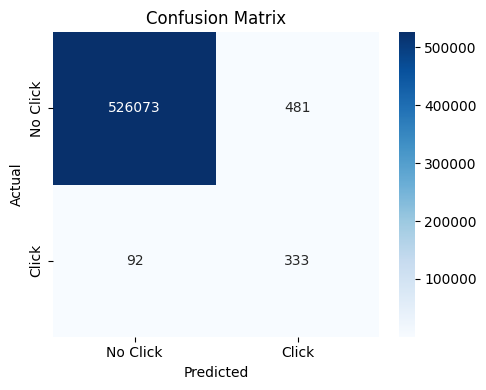

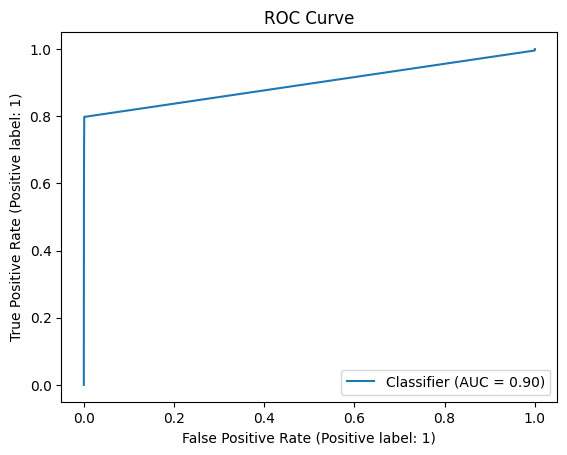

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, RocCurveDisplay
)

# === Predict probabilities and binary outcomes ===
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)

# === Compute metrics ===
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# === Class distribution ===
clicked = int(np.sum(y_test == 1))
not_clicked = int(np.sum(y_test == 0))

# === Print to console ===
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\nTP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Class Distribution:\nClicked: {clicked}, Not Clicked: {not_clicked}")

# === Plot confusion matrix ===
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Click', 'Click'], yticklabels=['No Click', 'Click'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("analytics/vertical_ecommerce_confusion_matrix.png")
plt.show()

# === Plot ROC Curve ===
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title("ROC Curve")
plt.savefig("analytics/vertical_ecommerce_roc_curve.png")
plt.show()

# === Prepare for JSON export ===
metrics = {
    "auc_roc": round(auc_roc, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1_score": round(f1, 4),
    "confusion_matrix": {
        "true_positive": int(tp),
        "false_positive": int(fp),
        "true_negative": int(tn),
        "false_negative": int(fn)
    },
    "class_distribution": {
        "clicked": clicked,
        "not_clicked": not_clicked
    }
}

from sklearn.metrics import roc_curve
import json

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

roc_data = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist()
}

with open("analytics/vertical_ecommerce_roc_data.json", "w") as f:
    json.dump(roc_data, f)


# === Save to JSON ===
with open("analytics/vertical_ecommerce_performance_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

In [9]:
# 1. How many total positive samples (clicks)?
total_clicks = df[df['Click'] == 1].shape[0]

# 2. How many of those clicks have user_profile_11278 == 0?
clicks_with_feature_zero = df[(df['Click'] == 1) & (df['In-market_clothing_shoes_and_bags'] == 0)].shape[0]

# 3. Percentage
percent = (clicks_with_feature_zero / total_clicks) * 100

print(f"{percent:.2f}% of clicks have In-market_clothing_shoes_and_bags == 0")


20.95% of clicks have In-market_clothing_shoes_and_bags == 0


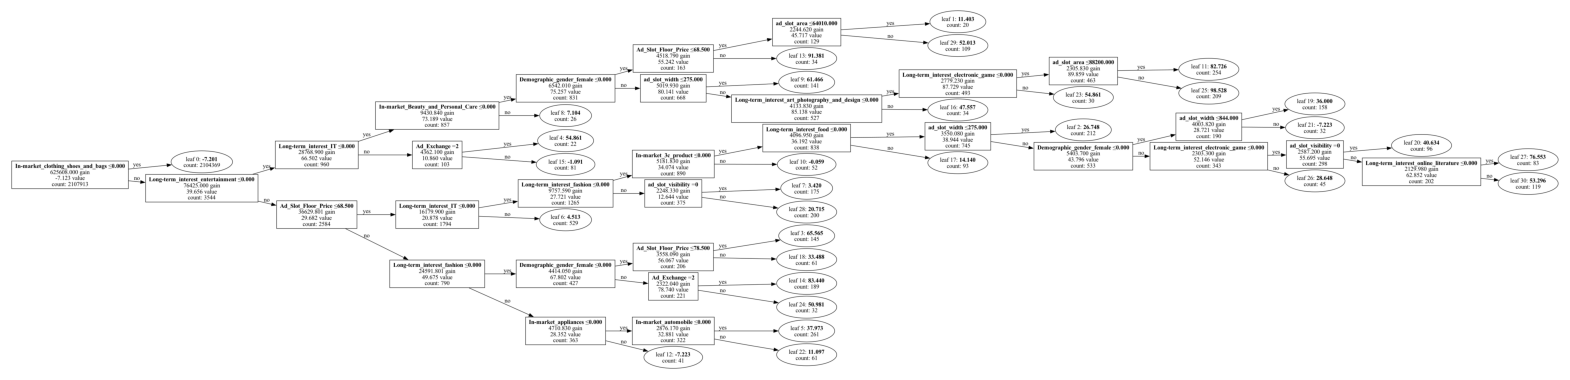

In [10]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Assuming you've already trained your model
# model = lgb.train(...)

# Plot a single tree (e.g., tree number 0)
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])

plt.show()

In [11]:
lgb.create_tree_digraph(model, tree_index=0, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count']).render('analytics/verticalEcommerce', format='png')

'analytics/verticalEcommerce.png'

In [12]:
y_pred_proba[y_pred_proba < 0.5]

array([0.000745, 0.000745, 0.000745, ..., 0.000745, 0.000745, 0.000745])

In [13]:
X_train.columns

Index(['hour', 'minute', 'day_of_the_week', 'is_weekend', 'part_of_the_day',
       'os_family', 'browser_family', 'device_type', 'ip_subnet_hash',
       'Region_ID', 'City_ID', 'Ad_Exchange', 'Domain_Cat',
       'Ad_Slot_ID_grouped', 'ad_slot_width', 'ad_slot_height',
       'ad_slot_ratio', 'ad_slot_area', 'ad_slot_visibility', 'Ad_Slot_Format',
       'Ad_Slot_Floor_Price', 'Creative_ID', 'Long-term_interest_news',
       'Long-term_interest_education', 'Long-term_interest_automobile',
       'Long-term_interest_real_estate', 'Long-term_interest_IT',
       'Long-term_interest_electronic_game', 'Long-term_interest_fashion',
       'Long-term_interest_entertainment', 'Long-term_interest_luxury',
       'Long-term_interest_home_and_lifestyle', 'Long-term_interest_health',
       'Long-term_interest_food', 'Long-term_interest_divine',
       'Long-term_interest_motherhood_and_parenting',
       'Long-term_interest_sports', 'Long-term_interest_travel_and_outdoors',
       'Long-term_i

In [14]:
from sklearn.metrics import confusion_matrix

y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[526073    481]
 [    92    333]]


In [15]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.5375302663438257

In [16]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, average_precision_score, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    526554
           1       0.41      0.78      0.54       425

    accuracy                           1.00    526979
   macro avg       0.70      0.89      0.77    526979
weighted avg       1.00      1.00      1.00    526979

ROC AUC Score: 0.8913079626043606


                                          feature     importance
43              In-market_clothing_shoes_and_bags  625608.000000
29               Long-term_interest_entertainment   76425.000000
26                          Long-term_interest_IT   44948.800781
20                            Ad_Slot_Floor_Price   44706.680908
28                     Long-term_interest_fashion   34349.390625
40                      Demographic_gender_female   16359.759766
14                                  ad_slot_width   12573.830322
44             In-market_Beauty_and_Personal_Care    9430.839844
11                                    Ad_Exchange    6684.140137
41                           In-market_3c_product    5181.830078
27             Long-term_interest_electronic_game    5082.530029
18                             ad_slot_visibility    4835.530029
42                           In-market_appliances    4710.830078
17                                   ad_slot_area    4550.450195
57  Long-term_interest_ar

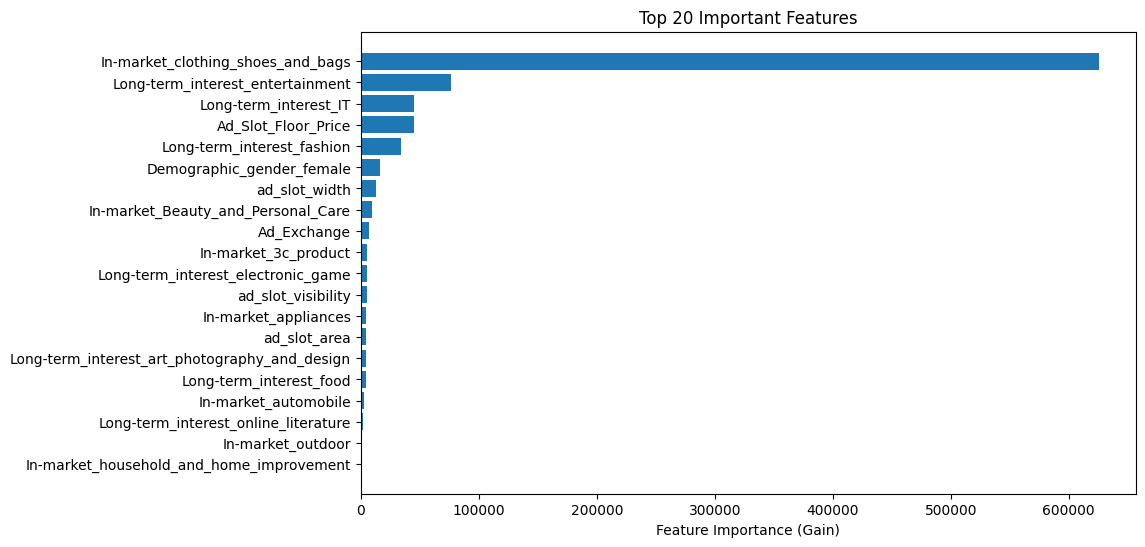

In [17]:
import matplotlib.pyplot as plt

# Get feature importances
importance = model.feature_importance(importance_type='gain')  # or 'split'

# Get feature names (must match training data features)
feature_names = X_train.columns

# Create a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

feat_imp_df.to_json("analytics/vertical_ecommerce_feature_importances.json", orient="records")

# Display top features
print(feat_imp_df.head(20))

# Plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'][:20][::-1], feat_imp_df['importance'][:20][::-1])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Important Features')
plt.show()

In [18]:
import os
# Ensure analytics folder exists
os.makedirs("analytics", exist_ok=True)

def plot_and_export_histogram(bids_array, filename_prefix, color):
    # Compute histogram data
    counts, bin_edges = np.histogram(bids_array, bins=50)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Plot histogram
    plt.figure(figsize=(10,6))
    plt.hist(bids_array, bins=50, color=color, edgecolor='black')
    plt.title(f"Bid Distribution Histogram ({filename_prefix.replace('_', ' ').title()})")
    plt.xlabel("Bid Value")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    
    # Prepare data for JSON export
    hist_data = {
        "labels": bin_centers.tolist(),
        "counts": counts.tolist()
    }
    
    # Save to JSON
    json_path = os.path.join("analytics", f"{filename_prefix}_histogram.json")
    with open(json_path, "w") as f:
        json.dump(hist_data, f)
    
    print(f"Exported histogram data to {json_path}")


Sample calibrated probabilities: [0.000176 0.000176 0.000176 0.000176 0.000176]
Sample bid prices: [0.11975045 0.11975045 0.11975045 0.11975045 0.11975045]


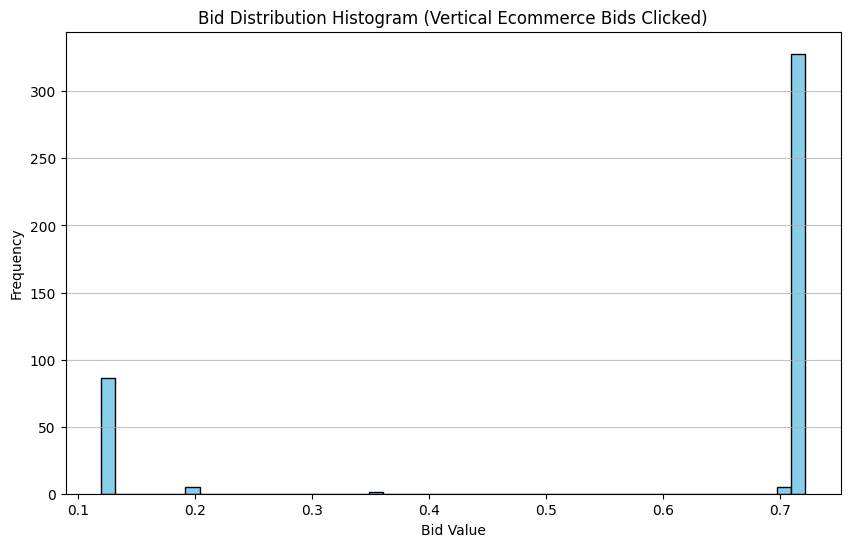

Exported histogram data to analytics/vertical_ecommerce_bids_clicked_histogram.json


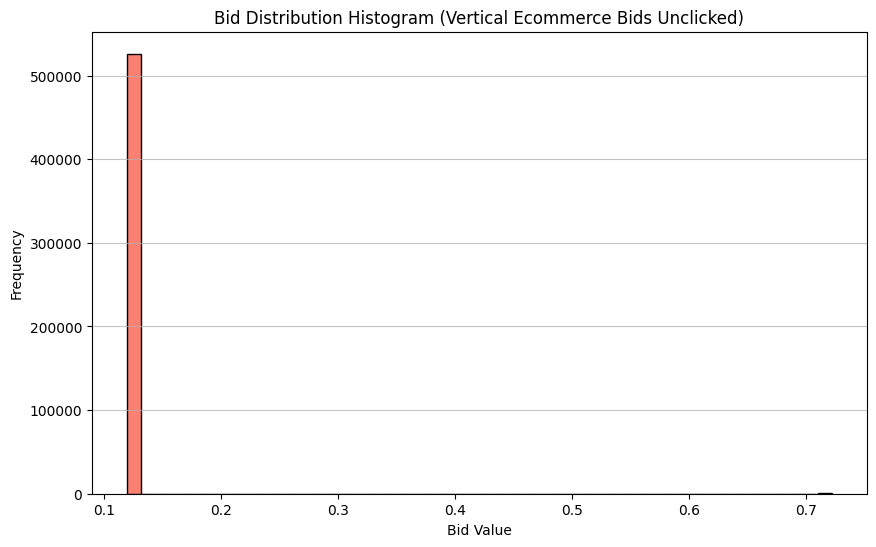

Exported histogram data to analytics/vertical_ecommerce_bids_unclicked_histogram.json


In [19]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Step 1: Get raw predicted probabilities from LightGBM Booster
raw_probs = model.predict(X_train)  # on training set or validation set

# Step 2: Fit sigmoid calibration model (logistic regression on raw probs)
calibrator = LogisticRegression()
calibrator.fit(raw_probs.reshape(-1, 1), y_train)

# Step 3: Apply calibration on test set
raw_probs_test = model.predict(X_test)
calibrated_probs = calibrator.predict_proba(raw_probs_test.reshape(-1, 1))[:, 1]

# Now you have calibrated probabilities like from Platt scaling

# Example bidding logic
base_bid = 0.1
avg_ctr = y_train.mean()
bids = base_bid * (1 + np.log1p(calibrated_probs / avg_ctr))

print("Sample calibrated probabilities:", calibrated_probs[:5])
print("Sample bid prices:", bids[:5])

# Assume bids and y_test arrays already defined
bids_clicked = bids[y_test == 1]
bids_unclicked = bids[y_test == 0]

# Plot and export clicked bids histogram
plot_and_export_histogram(bids_clicked, "vertical_ecommerce_bids_clicked", "skyblue")

# Plot and export unclicked bids histogram
plot_and_export_histogram(bids_unclicked, "vertical_ecommerce_bids_unclicked", "salmon")

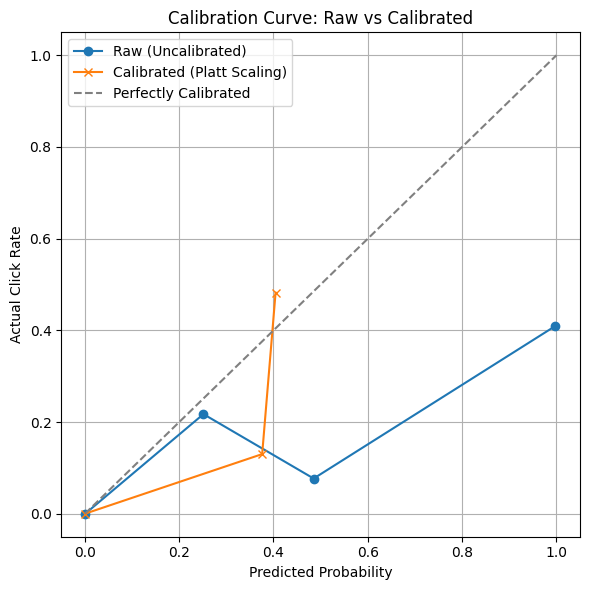

Brier Score (Uncalibrated): 0.0011
Brier Score (Calibrated): 0.0005


In [20]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute curves
prob_true_raw, prob_pred_raw = calibration_curve(y_test, raw_probs_test, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_probs, n_bins=10)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred_raw, prob_true_raw, marker='o', label='Raw (Uncalibrated)')
plt.plot(prob_pred_cal, prob_true_cal, marker='x', label='Calibrated (Platt Scaling)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Click Rate")
plt.title("Calibration Curve: Raw vs Calibrated")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("analytics/vertical_ecommerce_calibration_curve.png")  # Save to your folder
plt.show()

from sklearn.metrics import brier_score_loss

brier_raw = brier_score_loss(y_test, raw_probs_test)
brier_cal = brier_score_loss(y_test, calibrated_probs)

print(f"Brier Score (Uncalibrated): {brier_raw:.4f}")
print(f"Brier Score (Calibrated): {brier_cal:.4f}")

# Import for 3358 ( Software )

In [21]:
df = pd.read_csv("processed_advertiser_3358.csv")

In [22]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

categorical_columns = [
    'hour', 'day_of_the_week', 'is_weekend', 'part_of_the_day',
    'ip_subnet_hash', 'Domain_Cat',
    'os_family', 'browser_family', 'device_type', 'Region_ID',
    'City_ID', 'Ad_Exchange', 'Ad_Slot_ID_grouped', 'ad_slot_visibility',
    'Ad_Slot_Format', 'Creative_ID'
]

df['User_Profile_IDs'] = df['User_Profile_IDs'].fillna("")
df['User_Profile_IDs'] = df['User_Profile_IDs'].apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])

mlb = MultiLabelBinarizer()
user_profile_encoded = pd.DataFrame(
    mlb.fit_transform(df['User_Profile_IDs']),
    columns=[f"User_Profile_{id_}" for id_ in mlb.classes_],
    index=df.index
)

# Rename user_profile_encoded columns using the mapping
user_profile_encoded.rename(
    columns=lambda col: USER_PROFILE_ID_TO_INTEREST.get(col.split("_")[-1], col),
    inplace=True
)

for col in categorical_columns:
    df[col] = df[col].astype('category')

df = pd.concat([df.drop('User_Profile_IDs', axis=1), user_profile_encoded], axis=1)

X = df.drop('Click', axis=1)
y = df['Click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_feats = [col for col in categorical_columns if col in X.columns]

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feats)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train, categorical_feature=categorical_feats)

# Step 7: Train LightGBM
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_test],  callbacks=[lgb.early_stopping(stopping_rounds=50)])

# Step 8: Predict and evaluate
y_pred_proba = model.predict(X_test)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.82346	valid_1's auc: 0.862228


In [23]:
lgb.create_tree_digraph(model, tree_index=0, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count']).render('analytics/software', format='png')

'analytics/software.png'

In [24]:
y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[309666    633]
 [    85    163]]


                               feature    importance
17                        ad_slot_area  45625.389648
60               Long-term_interest_3c  39885.398438
42                In-market_appliances  31913.099609
41                In-market_3c_product  27308.000000
20                 Ad_Slot_Floor_Price  19817.800781
29    Long-term_interest_entertainment  17867.350464
22             Long-term_interest_news  14326.299805
47               In-market_sports_item   9762.549805
7                          device_type   8695.540039
11                         Ad_Exchange   8279.860352
40           Demographic_gender_female   6900.520142
32           Long-term_interest_health   6717.000000
23        Long-term_interest_education   6370.020020
24       Long-term_interest_automobile   5468.270020
39             Demographic_gender_male   4141.329956
27  Long-term_interest_electronic_game   3208.570068
59           In-market_electronic_game   2896.600098
1                               minute   1287.

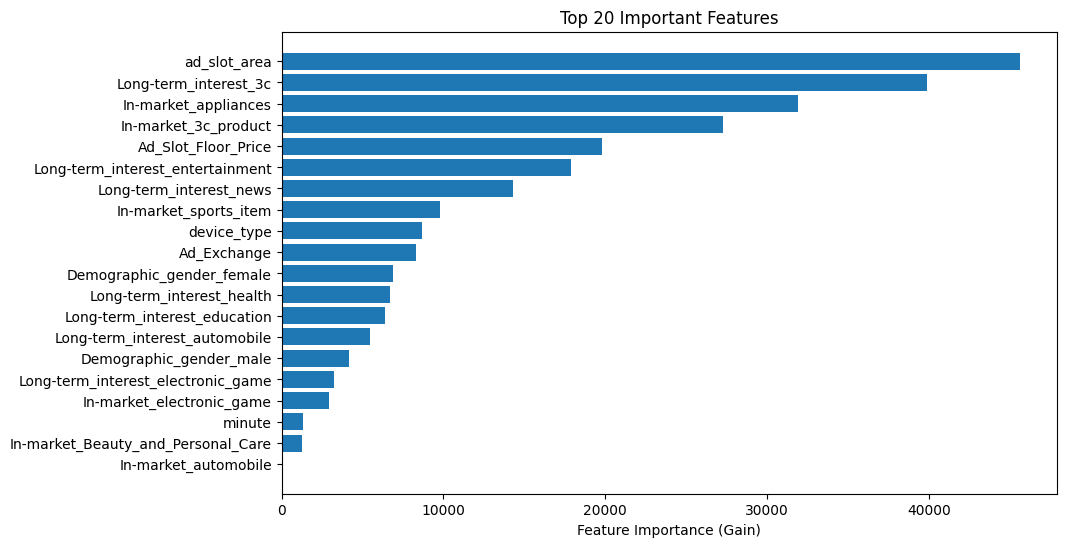

In [25]:
import matplotlib.pyplot as plt

# Get feature importances
importance = model.feature_importance(importance_type='gain')  # or 'split'

# Get feature names (must match training data features)
feature_names = X_train.columns

# Create a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Display top features
print(feat_imp_df.head(20))

# Plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'][:20][::-1], feat_imp_df['importance'][:20][::-1])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Important Features')
plt.show()

Sample calibrated probabilities: [0.00033361 0.00033361 0.00033361 0.00033361 0.00033361]
Sample bid prices: [0.13490685 0.13490685 0.13490685 0.13490685 0.13490685]


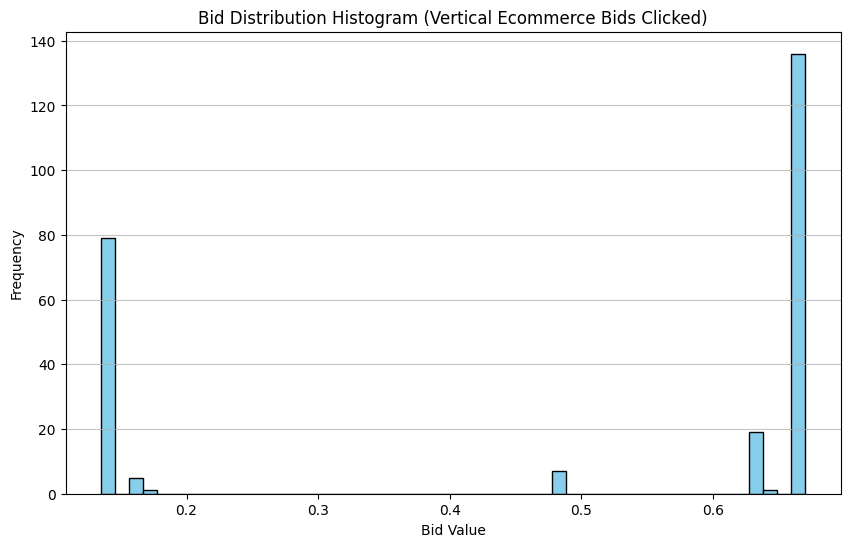

Exported histogram data to analytics/vertical_ecommerce_bids_clicked_histogram.json


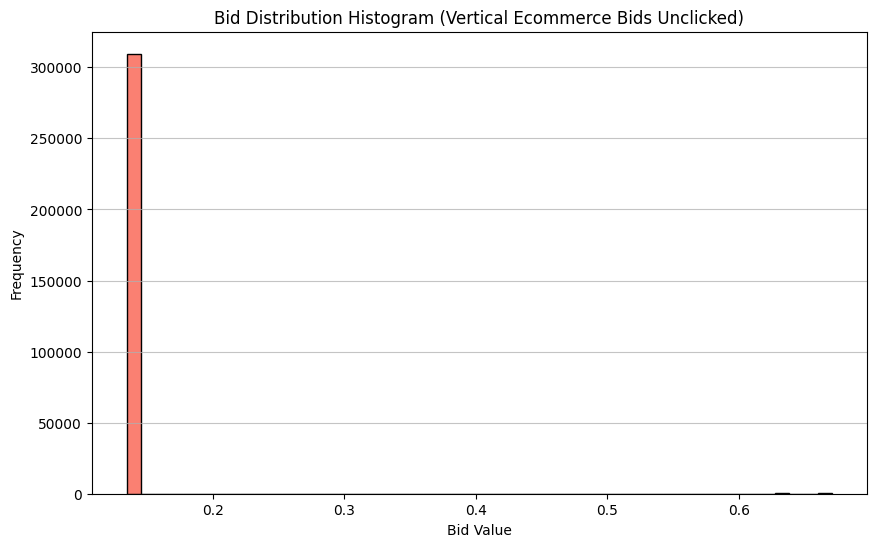

Exported histogram data to analytics/vertical_ecommerce_bids_unclicked_histogram.json


In [26]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Step 1: Get raw predicted probabilities from LightGBM Booster
raw_probs = model.predict(X_train)  # on training set or validation set

# Step 2: Fit sigmoid calibration model (logistic regression on raw probs)
calibrator = LogisticRegression()
calibrator.fit(raw_probs.reshape(-1, 1), y_train)

# Step 3: Apply calibration on test set
raw_probs_test = model.predict(X_test)
calibrated_probs = calibrator.predict_proba(raw_probs_test.reshape(-1, 1))[:, 1]

# Now you have calibrated probabilities like from Platt scaling

# Example bidding logic
base_bid = 0.1
avg_ctr = y_train.mean()
bids = base_bid * (1 + np.log1p(calibrated_probs / avg_ctr))

print("Sample calibrated probabilities:", calibrated_probs[:5])
print("Sample bid prices:", bids[:5])

# Assume bids and y_test arrays already defined
bids_clicked = bids[y_test == 1]
bids_unclicked = bids[y_test == 0]

# Plot and export clicked bids histogram
plot_and_export_histogram(bids_clicked, "vertical_ecommerce_bids_clicked", "skyblue")

# Plot and export unclicked bids histogram
plot_and_export_histogram(bids_unclicked, "vertical_ecommerce_bids_unclicked", "salmon")

# Creating Personal User profile to test click through prediction

In [27]:
import pandas as pd

# Your user profile IDs
user_profile_ids = ['10024', '10052', '10057', '10093',
                    '11379', '11680', '13496', '13678',
                    '13800', '13874']

# Multi-hot encode user profile IDs using trained mlb
user_profile_encoded = pd.DataFrame(
    mlb.transform([user_profile_ids]),
    columns=[f"User_Profile_{id_}" for id_ in mlb.classes_]
)

# Input feature values with corrected ad_slot_ratio
test_data = {
    'hour': pd.Categorical([15]),
    'day_of_the_week': pd.Categorical([2]),
    'is_weekend': pd.Categorical([0]),
    'part_of_the_day': pd.Categorical(['afternoon']),
    'ip_subnet_hash': pd.Categorical(['Other']),
    'Domain_Cat': pd.Categorical(['Other']),
    'os_family': pd.Categorical(['Mac']),
    'browser_family': pd.Categorical(['Safari']),
    'device_type': pd.Categorical(['desktop']),
    'Region_ID': pd.Categorical(['0']),
    'City_ID': pd.Categorical(['0']),
    'Ad_Exchange': pd.Categorical(['2']),
    'Ad_Slot_ID_grouped': pd.Categorical(['Other']),
    'ad_slot_visibility': pd.Categorical(['0']),
    'Ad_Slot_Format': pd.Categorical(['1']),
    'Creative_ID': pd.Categorical(['e1b0b6fb39abeb138c0b1e37c5f6d777']),

    # Numeric fields (including fixed ad_slot_ratio)
    'minute': [27.71],
    'ad_slot_width': [568.8276],
    'ad_slot_height': [195.131],
    'ad_slot_ratio': [5.203],
    'ad_slot_area': [79034.61],
    'Ad_Slot_Floor_Price': [17.428],
}

# Create test DataFrame
test_df = pd.DataFrame(test_data)

# Concatenate with multi-hot user profile encoding
final_test_df = pd.concat([test_df, user_profile_encoded], axis=1)

# Reorder to match training data columns
final_test_df = final_test_df.reindex(columns=X_train.columns, fill_value=0)

# Predict
y_pred_proba = model.predict(final_test_df)
print("🔍 Predicted click probability:", y_pred_proba[0])

🔍 Predicted click probability: 0.000748488788517007


It is predicted that i will not click on this as this is way less than 0.5

# Import for 3386 ( International e-commerce )

In [28]:
df = pd.read_csv("processed_advertiser_3386.csv")

import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

categorical_columns = [
    'hour', 'day_of_the_week', 'is_weekend', 'part_of_the_day',
    'ip_subnet_hash', 'Domain_Cat',
    'os_family', 'browser_family', 'device_type', 'Region_ID',
    'City_ID', 'Ad_Exchange', 'Ad_Slot_ID_grouped', 'ad_slot_visibility',
    'Ad_Slot_Format', 'Creative_ID'
]

df['User_Profile_IDs'] = df['User_Profile_IDs'].fillna("")
df['User_Profile_IDs'] = df['User_Profile_IDs'].apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])

mlb = MultiLabelBinarizer()
user_profile_encoded = pd.DataFrame(
    mlb.fit_transform(df['User_Profile_IDs']),
    columns=[f"User_Profile_{id_}" for id_ in mlb.classes_],
    index=df.index
)

for col in categorical_columns:
    df[col] = df[col].astype('category')

df = pd.concat([df.drop('User_Profile_IDs', axis=1), user_profile_encoded], axis=1)

X = df.drop('Click', axis=1)
y = df['Click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_feats = [col for col in categorical_columns if col in X.columns]

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feats)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train, categorical_feature=categorical_feats)

# Step 7: Train LightGBM
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_test],  callbacks=[lgb.early_stopping(stopping_rounds=50)])

# Step 8: Predict and evaluate
y_pred_proba = model.predict(X_test)
joblib.dump(mlb, 'mlb.pkl')
joblib.dump(X_train.columns, 'X_train_columns.pkl')


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.809253	valid_1's auc: 0.709092


['X_train_columns.pkl']

# Visualizing Important Features

[[481940     80]
 [   354      7]]
               feature    importance
1               minute  29628.572250
3           is_weekend  10413.010279
7          device_type   9873.516857
19      Ad_Slot_Format   8232.734863
26  User_Profile_10052   6489.020096
14       ad_slot_width   6329.164963
29  User_Profile_10063   5516.483974
53  User_Profile_13403   4853.240234
60  User_Profile_14273   4697.470169
18  ad_slot_visibility   4144.003691
23  User_Profile_10024   3993.719971
44  User_Profile_11379   3525.920288
17        ad_slot_area   3445.268173
22  User_Profile_10006   3057.226597
37  User_Profile_10093   2554.823029
41  User_Profile_10684   2061.961025
13  Ad_Slot_ID_grouped   1922.013199
45  User_Profile_11423   1793.120762
10             City_ID   1671.379503
52  User_Profile_13042   1460.439877


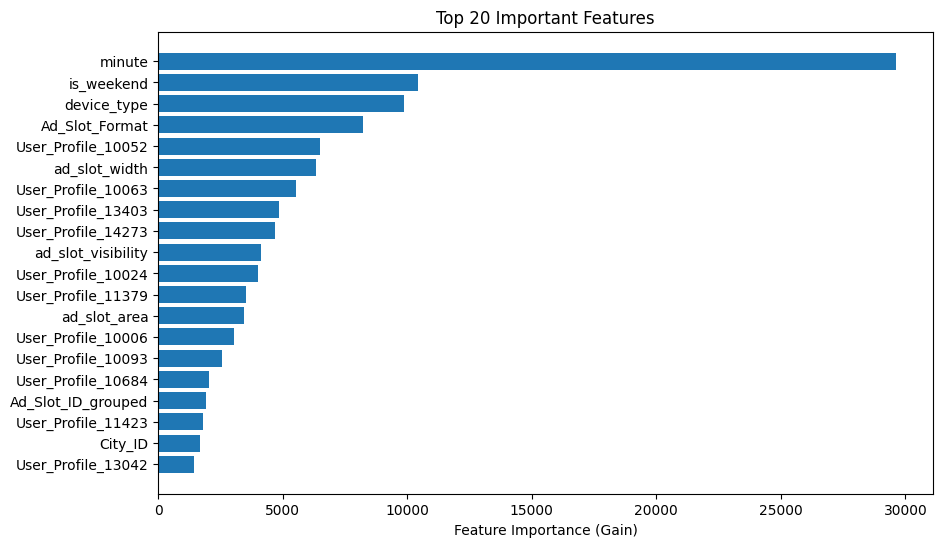

In [29]:
y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

import matplotlib.pyplot as plt

# Get feature importances
importance = model.feature_importance(importance_type='gain')  # or 'split'

# Get feature names (must match training data features)
feature_names = X_train.columns

# Create a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Display top features
print(feat_imp_df.head(20))

# Plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'][:20][::-1], feat_imp_df['importance'][:20][::-1])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Important Features')
plt.show()

In [30]:
import pandas as pd

# Your user profile IDs
user_profile_ids = ['10024', '10052', '10057', '10093',
                    '11379', '11680', '13496', '13678',
                    '13800', '13874']

# Multi-hot encode user profile IDs using trained mlb
user_profile_encoded = pd.DataFrame(
    mlb.transform([user_profile_ids]),
    columns=[f"User_Profile_{id_}" for id_ in mlb.classes_]
)

# Input feature values with corrected ad_slot_ratio
test_data = {
    'hour': pd.Categorical([15]),
    'day_of_the_week': pd.Categorical([2]),
    'is_weekend': pd.Categorical([0]),
    'part_of_the_day': pd.Categorical(['afternoon']),
    'ip_subnet_hash': pd.Categorical(['Other']),
    'Domain_Cat': pd.Categorical(['Other']),
    'os_family': pd.Categorical(['Mac']),
    'browser_family': pd.Categorical(['Safari']),
    'device_type': pd.Categorical(['desktop']),
    'Region_ID': pd.Categorical(['0']),
    'City_ID': pd.Categorical(['0']),
    'Ad_Exchange': pd.Categorical(['2']),
    'Ad_Slot_ID_grouped': pd.Categorical(['Other']),
    'ad_slot_visibility': pd.Categorical(['0']),
    'Ad_Slot_Format': pd.Categorical(['1']),
    'Creative_ID': pd.Categorical(['e1b0b6fb39abeb138c0b1e37c5f6d777']),

    # Numeric fields (including fixed ad_slot_ratio)
    'minute': [27.71],
    'ad_slot_width': [568.8276],
    'ad_slot_height': [195.131],
    'ad_slot_ratio': [5.203],
    'ad_slot_area': [79034.61],
    'Ad_Slot_Floor_Price': [17.428],
}

# Create test DataFrame
test_df = pd.DataFrame(test_data)

# Concatenate with multi-hot user profile encoding
final_test_df = pd.concat([test_df, user_profile_encoded], axis=1)

# Reorder to match training data columns
final_test_df = final_test_df.reindex(columns=X_train.columns, fill_value=0)

# Predict
y_pred_proba = model.predict(final_test_df)
print("🔍 Predicted click probability:", y_pred_proba[0])

🔍 Predicted click probability: 0.0005512983506870842


# Import for 3427 ( Oil )

In [31]:
df = pd.read_csv("processed_advertiser_3427.csv")

import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

categorical_columns = [
    'hour', 'day_of_the_week', 'is_weekend', 'part_of_the_day',
    'ip_subnet_hash', 'Domain_Cat',
    'os_family', 'browser_family', 'device_type', 'Region_ID',
    'City_ID', 'Ad_Exchange', 'Ad_Slot_ID_grouped', 'ad_slot_visibility',
    'Ad_Slot_Format', 'Creative_ID'
]

df['User_Profile_IDs'] = df['User_Profile_IDs'].fillna("")
df['User_Profile_IDs'] = df['User_Profile_IDs'].apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])

mlb = MultiLabelBinarizer()
user_profile_encoded = pd.DataFrame(
    mlb.fit_transform(df['User_Profile_IDs']),
    columns=[f"User_Profile_{id_}" for id_ in mlb.classes_],
    index=df.index
)

# Rename user_profile_encoded columns using the mapping
user_profile_encoded.rename(
    columns=lambda col: USER_PROFILE_ID_TO_INTEREST.get(col.split("_")[-1], col),
    inplace=True
)

for col in categorical_columns:
    df[col] = df[col].astype('category')

df = pd.concat([df.drop('User_Profile_IDs', axis=1), user_profile_encoded], axis=1)

X = df.drop('Click', axis=1)
y = df['Click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_feats = [col for col in categorical_columns if col in X.columns]

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feats)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train, categorical_feature=categorical_feats)

# Step 7: Train LightGBM
params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 20,
    'verbosity': -1
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_test],  callbacks=[lgb.early_stopping(stopping_rounds=50)])
joblib.dump(model, "lightgbm_model_oil.pkl")

# Step 8: Predict and evaluate
y_pred_proba = model.predict(X_test)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.872078	valid_1's auc: 0.872076


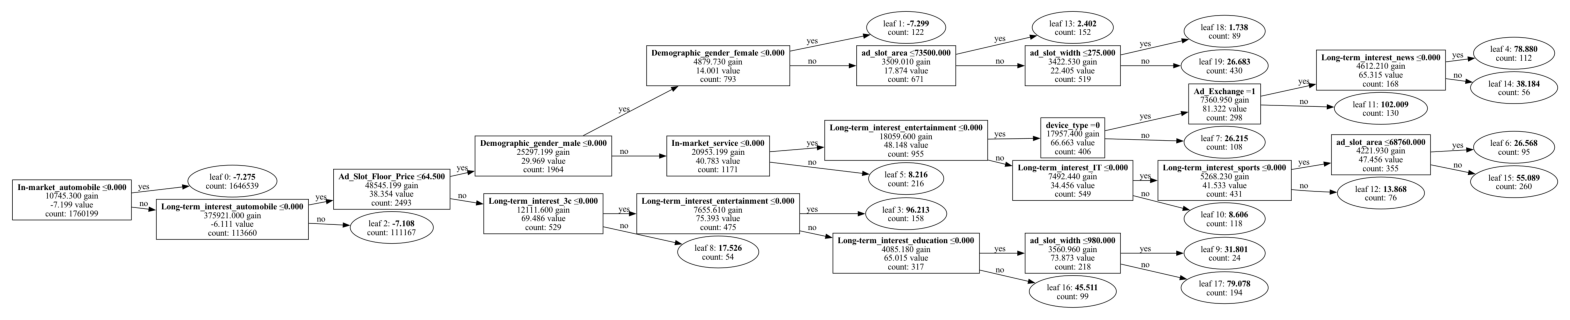

In [32]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Assuming you've already trained your model
# model = lgb.train(...)

# Plot a single tree (e.g., tree number 0)
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])

plt.show()

In [33]:
lgb.create_tree_digraph(model, tree_index=0, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count']).render('analytics/oilTree', format='png')

'analytics/oilTree.png'

AUC-ROC: 0.8721
Precision: 0.3497
Recall: 0.6311
F1 Score: 0.4500
Confusion Matrix:
TP: 207, FP: 385, TN: 439337, FN: 121
Class Distribution:
Clicked: 328, Not Clicked: 439722


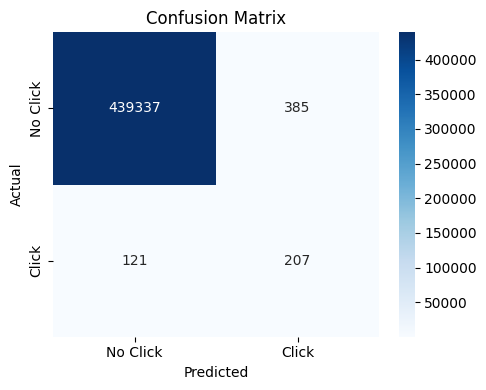

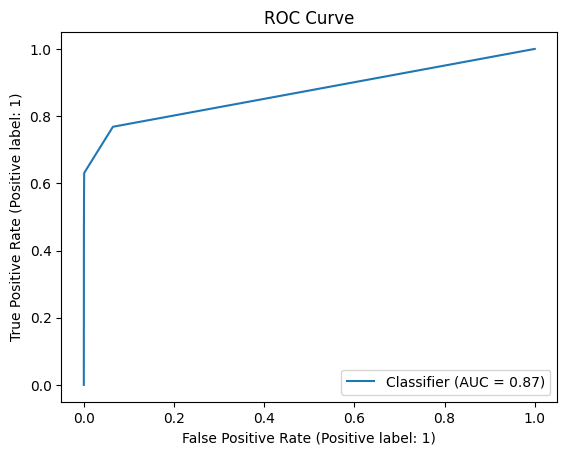

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, RocCurveDisplay
)

# === Predict probabilities and binary outcomes ===
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)

# === Compute metrics ===
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# === Class distribution ===
clicked = int(np.sum(y_test == 1))
not_clicked = int(np.sum(y_test == 0))

# === Print to console ===
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\nTP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Class Distribution:\nClicked: {clicked}, Not Clicked: {not_clicked}")

# === Plot confusion matrix ===
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Click', 'Click'], yticklabels=['No Click', 'Click'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("analytics/oil_confusion_matrix.png")
plt.show()

# === Plot ROC Curve ===
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title("ROC Curve")
plt.savefig("analytics/oil_roc_curve.png")
plt.show()

# === Prepare for JSON export ===
metrics = {
    "auc_roc": round(auc_roc, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1_score": round(f1, 4),
    "confusion_matrix": {
        "true_positive": int(tp),
        "false_positive": int(fp),
        "true_negative": int(tn),
        "false_negative": int(fn)
    },
    "class_distribution": {
        "clicked": clicked,
        "not_clicked": not_clicked
    }
}

from sklearn.metrics import roc_curve
import json

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

roc_data = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist()
}

with open("analytics/oil_roc_data.json", "w") as f:
    json.dump(roc_data, f)

# === Save to JSON ===
with open("analytics/oil_performance_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

# Visualizing Important Features

[[439337    385]
 [   121    207]]
                               feature     importance
24       Long-term_interest_automobile  375921.000000
20                 Ad_Slot_Floor_Price   48545.199219
29    Long-term_interest_entertainment   25715.209473
39             Demographic_gender_male   25297.199219
56                   In-market_service   20953.199219
7                          device_type   17957.400391
60               Long-term_interest_3c   12111.599609
52                In-market_automobile   10745.299805
17                        ad_slot_area    7730.940186
26               Long-term_interest_IT    7492.439941
11                         Ad_Exchange    7360.950195
14                       ad_slot_width    6983.489990
36           Long-term_interest_sports    5268.229980
40           Demographic_gender_female    4879.729980
22             Long-term_interest_news    4612.209961
23        Long-term_interest_education    4085.179932
46   In-market_infant_and_mom_products       0.

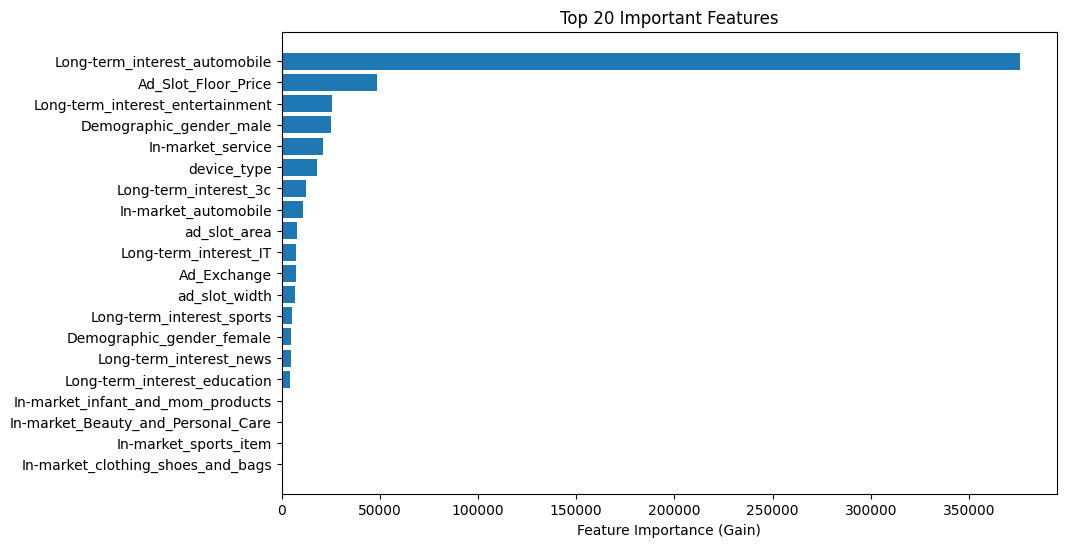

In [35]:
y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

import matplotlib.pyplot as plt

# Get feature importances
importance = model.feature_importance(importance_type='gain')  # or 'split'

# Get feature names (must match training data features)
feature_names = X_train.columns

# Create a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Display top features
print(feat_imp_df.head(20))

feat_imp_df.to_json("analytics/oil_feature_importances.json", orient="records")

# Plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'][:20][::-1], feat_imp_df['importance'][:20][::-1])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Important Features')
plt.show()

In [36]:
import pandas as pd

# Your user profile IDs
user_profile_ids = ['10024', '10052', '10057', '10093',
                    '11379', '11680', '13496', '13678',
                    '13800', '13874']

# Multi-hot encode user profile IDs using trained mlb
user_profile_encoded = pd.DataFrame(
    mlb.transform([user_profile_ids]),
    columns=[f"User_Profile_{id_}" for id_ in mlb.classes_]
)

# Input feature values with corrected ad_slot_ratio
test_data = {
    'hour': pd.Categorical([15]),
    'day_of_the_week': pd.Categorical([2]),
    'is_weekend': pd.Categorical([0]),
    'part_of_the_day': pd.Categorical(['afternoon']),
    'ip_subnet_hash': pd.Categorical(['Other']),
    'Domain_Cat': pd.Categorical(['Other']),
    'os_family': pd.Categorical(['Mac']),
    'browser_family': pd.Categorical(['Safari']),
    'device_type': pd.Categorical(['desktop']),
    'Region_ID': pd.Categorical(['0']),
    'City_ID': pd.Categorical(['0']),
    'Ad_Exchange': pd.Categorical(['2']),
    'Ad_Slot_ID_grouped': pd.Categorical(['Other']),
    'ad_slot_visibility': pd.Categorical(['0']),
    'Ad_Slot_Format': pd.Categorical(['1']),
    'Creative_ID': pd.Categorical(['e1b0b6fb39abeb138c0b1e37c5f6d777']),

    # Numeric fields (including fixed ad_slot_ratio)
    'minute': [27.71],
    'ad_slot_width': [568.8276],
    'ad_slot_height': [195.131],
    'ad_slot_ratio': [5.203],
    'ad_slot_area': [79034.61],
    'Ad_Slot_Floor_Price': [17.428],
}

# Create test DataFrame
test_df = pd.DataFrame(test_data)

# Concatenate with multi-hot user profile encoding
final_test_df = pd.concat([test_df, user_profile_encoded], axis=1)

# Reorder to match training data columns
final_test_df = final_test_df.reindex(columns=X_train.columns, fill_value=0)

# Predict
y_pred_proba = model.predict(final_test_df)
print("🔍 Predicted click probability:", y_pred_proba[0])

🔍 Predicted click probability: 0.0006924925525547722


Sample calibrated probabilities: [0.000267 0.000267 0.000267 0.000267 0.000267]
Sample bid prices: [0.13057709 0.13057709 0.13057709 0.13057709 0.13057709]


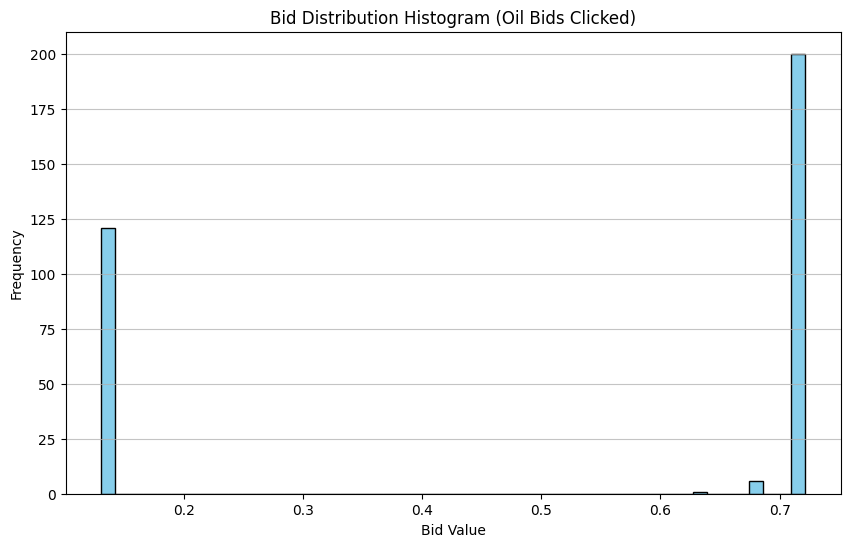

Exported histogram data to analytics/oil_bids_clicked_histogram.json


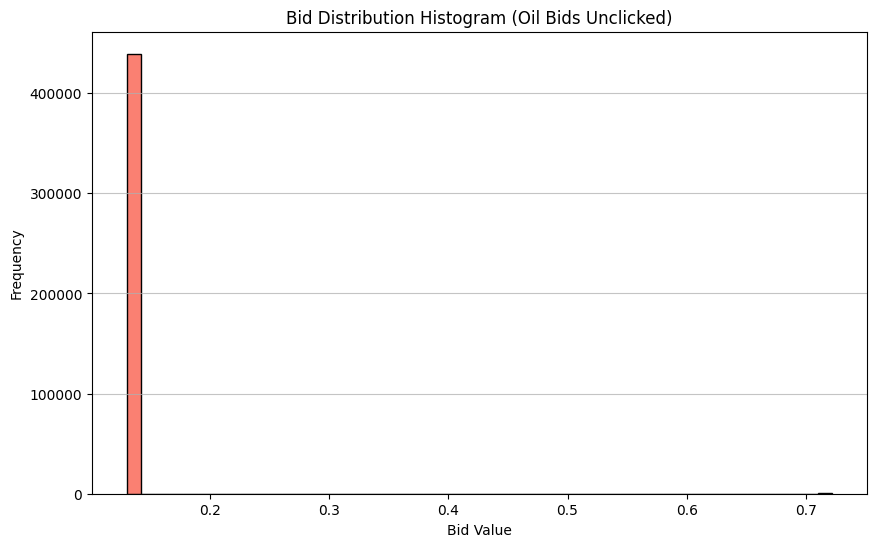

Exported histogram data to analytics/oil_bids_unclicked_histogram.json


In [37]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Step 1: Get raw predicted probabilities from LightGBM Booster
raw_probs = model.predict(X_train)  # on training set or validation set

# Step 2: Fit sigmoid calibration model (logistic regression on raw probs)
calibrator = LogisticRegression()
calibrator.fit(raw_probs.reshape(-1, 1), y_train)

# Step 3: Apply calibration on test set
raw_probs_test = model.predict(X_test)
calibrated_probs = calibrator.predict_proba(raw_probs_test.reshape(-1, 1))[:, 1]

# Now you have calibrated probabilities like from Platt scaling

# Example bidding logic
base_bid = 0.1
avg_ctr = y_train.mean()
bids = base_bid * (1 + np.log1p(calibrated_probs / avg_ctr))

print("Sample calibrated probabilities:", calibrated_probs[:5])
print("Sample bid prices:", bids[:5])

# Assume bids and y_test arrays already defined
bids_clicked = bids[y_test == 1]
bids_unclicked = bids[y_test == 0]

# Plot and export clicked bids histogram
plot_and_export_histogram(bids_clicked, "oil_bids_clicked", "skyblue")

# Plot and export unclicked bids histogram
plot_and_export_histogram(bids_unclicked, "oil_bids_unclicked", "salmon")

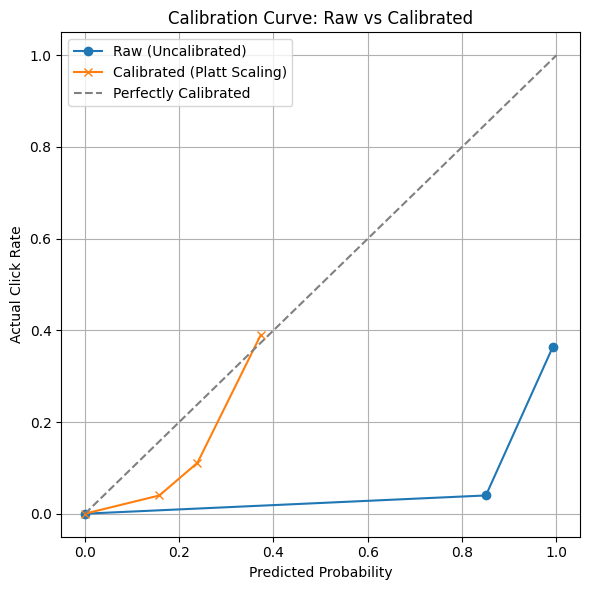

Brier Score (Uncalibrated): 0.0011
Brier Score (Calibrated): 0.0006


In [38]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute curves
prob_true_raw, prob_pred_raw = calibration_curve(y_test, raw_probs_test, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_probs, n_bins=10)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred_raw, prob_true_raw, marker='o', label='Raw (Uncalibrated)')
plt.plot(prob_pred_cal, prob_true_cal, marker='x', label='Calibrated (Platt Scaling)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Click Rate")
plt.title("Calibration Curve: Raw vs Calibrated")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("analytics/oil_calibration_curve.png")  # Save to your folder
plt.show()

from sklearn.metrics import brier_score_loss

brier_raw = brier_score_loss(y_test, raw_probs_test)
brier_cal = brier_score_loss(y_test, calibrated_probs)

print(f"Brier Score (Uncalibrated): {brier_raw:.4f}")
print(f"Brier Score (Calibrated): {brier_cal:.4f}")

# Import for 3476 ( Tire )

In [39]:
df = pd.read_csv("processed_advertiser_3476.csv")

import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

categorical_columns = [
    'hour', 'day_of_the_week', 'is_weekend', 'part_of_the_day',
    'ip_subnet_hash', 'Domain_Cat',
    'os_family', 'browser_family', 'device_type', 'Region_ID',
    'City_ID', 'Ad_Exchange', 'Ad_Slot_ID_grouped', 'ad_slot_visibility',
    'Ad_Slot_Format', 'Creative_ID'
]

df['User_Profile_IDs'] = df['User_Profile_IDs'].fillna("")
df['User_Profile_IDs'] = df['User_Profile_IDs'].apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])

mlb = MultiLabelBinarizer()
user_profile_encoded = pd.DataFrame(
    mlb.fit_transform(df['User_Profile_IDs']),
    columns=[f"User_Profile_{id_}" for id_ in mlb.classes_],
    index=df.index
)

# Rename user_profile_encoded columns using the mapping
user_profile_encoded.rename(
    columns=lambda col: USER_PROFILE_ID_TO_INTEREST.get(col.split("_")[-1], col),
    inplace=True
)

for col in categorical_columns:
    df[col] = df[col].astype('category')

df = pd.concat([df.drop('User_Profile_IDs', axis=1), user_profile_encoded], axis=1)

X = df.drop('Click', axis=1)
y = df['Click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_feats = [col for col in categorical_columns if col in X.columns]

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feats)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train, categorical_feature=categorical_feats)

# Step 7: Train LightGBM
params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 40,
    'verbosity': -1
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_test],  callbacks=[lgb.early_stopping(stopping_rounds=50)])
joblib.dump(model, "lightgbm_model_tire.pkl")

# Step 8: Predict and evaluate
y_pred_proba = model.predict(X_test)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.866766	valid_1's auc: 0.868491


# Visualizing Important Features

[[322705    318]
 [   100     70]]
                                 feature    importance
24         Long-term_interest_automobile  81429.898438
20                   Ad_Slot_Floor_Price  39034.360840
1                                 minute  13654.703918
39               Demographic_gender_male   9914.899902
58  Long-term_interest_online_literature   8074.789795
56                     In-market_service   7042.523071
18                    ad_slot_visibility   6049.921082
17                          ad_slot_area   5737.977234
3                             is_weekend   5434.022156
19                        Ad_Slot_Format   4539.950073
60                 Long-term_interest_3c   3902.639893
27    Long-term_interest_electronic_game   3725.728943
52                  In-market_automobile   2223.270020
28            Long-term_interest_fashion   2140.090088
29      Long-term_interest_entertainment   1098.180054
23          Long-term_interest_education   1009.658020
32             Long-term_inter

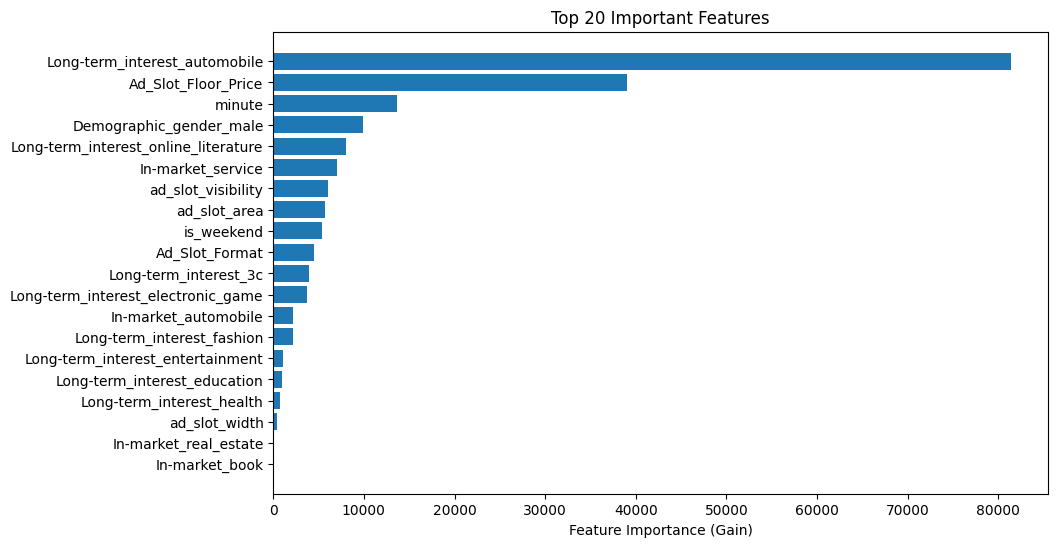

In [40]:
y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

import matplotlib.pyplot as plt

# Get feature importances
importance = model.feature_importance(importance_type='gain')  # or 'split'

# Get feature names (must match training data features)
feature_names = X_train.columns

# Create a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

feat_imp_df.to_json("analytics/oil_feature_importances.json", orient="records")
# Display top features
print(feat_imp_df.head(20))

# Plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'][:20][::-1], feat_imp_df['importance'][:20][::-1])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Important Features')
plt.show()

In [41]:
df.columns

Index(['hour', 'minute', 'day_of_the_week', 'is_weekend', 'part_of_the_day',
       'os_family', 'browser_family', 'device_type', 'ip_subnet_hash',
       'Region_ID', 'City_ID', 'Ad_Exchange', 'Domain_Cat',
       'Ad_Slot_ID_grouped', 'ad_slot_width', 'ad_slot_height',
       'ad_slot_ratio', 'ad_slot_area', 'ad_slot_visibility', 'Ad_Slot_Format',
       'Ad_Slot_Floor_Price', 'Creative_ID', 'Click',
       'Long-term_interest_news', 'Long-term_interest_education',
       'Long-term_interest_automobile', 'Long-term_interest_real_estate',
       'Long-term_interest_IT', 'Long-term_interest_electronic_game',
       'Long-term_interest_fashion', 'Long-term_interest_entertainment',
       'Long-term_interest_luxury', 'Long-term_interest_home_and_lifestyle',
       'Long-term_interest_health', 'Long-term_interest_food',
       'Long-term_interest_divine',
       'Long-term_interest_motherhood_and_parenting',
       'Long-term_interest_sports', 'Long-term_interest_travel_and_outdoors',
   

In [42]:
lgb.create_tree_digraph(model, tree_index=0, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count']).render('analytics/tireTree', format='png')

print("Downloaded")

Downloaded


In [43]:
df['os_family'].value_counts()

Windows    1602164
iOS           7585
Mac           3135
Linux         2710
Other          284
Android         84
Name: os_family, dtype: int64

Sample calibrated probabilities: [0.00030248 0.00030248 0.00030248 0.20465377 0.00030272]
Sample bid prices: [0.14553655 0.14553655 0.14553655 0.69692734 0.1455652 ]


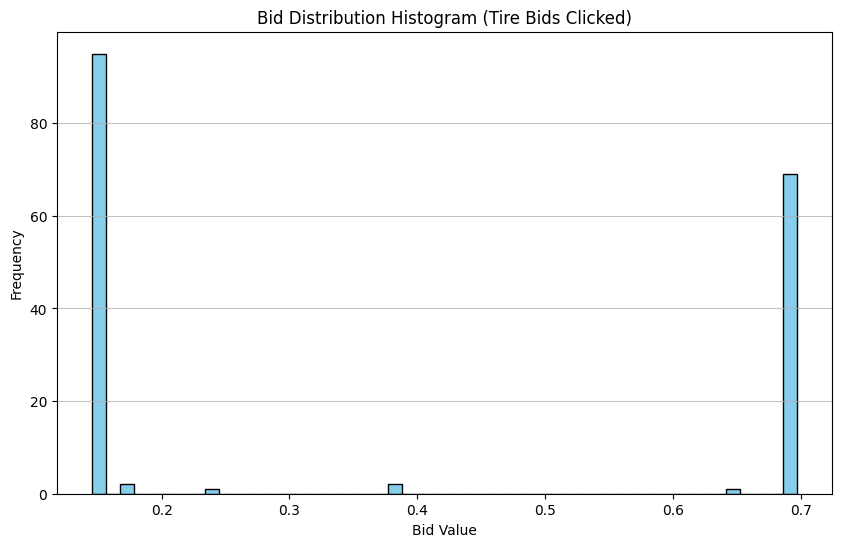

Exported histogram data to analytics/tire_bids_clicked_histogram.json


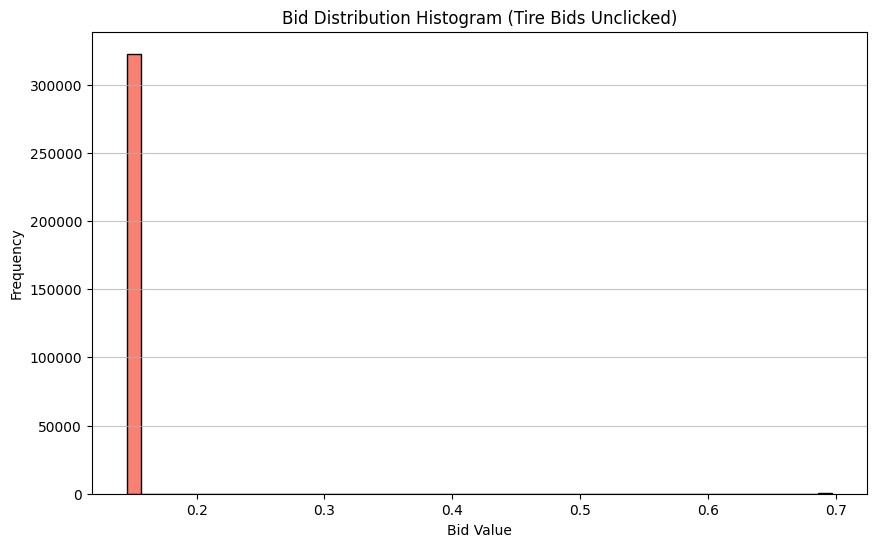

Exported histogram data to analytics/tire_bids_unclicked_histogram.json


In [44]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Step 1: Get raw predicted probabilities from LightGBM Booster
raw_probs = model.predict(X_train)  # on training set or validation set

# Step 2: Fit sigmoid calibration model (logistic regression on raw probs)
calibrator = LogisticRegression()
calibrator.fit(raw_probs.reshape(-1, 1), y_train)

# Step 3: Apply calibration on test set
raw_probs_test = model.predict(X_test)
calibrated_probs = calibrator.predict_proba(raw_probs_test.reshape(-1, 1))[:, 1]

# Now you have calibrated probabilities like from Platt scaling

# Example bidding logic
base_bid = 0.1
avg_ctr = y_train.mean()
bids = base_bid * (1 + np.log1p(calibrated_probs / avg_ctr))

print("Sample calibrated probabilities:", calibrated_probs[:5])
print("Sample bid prices:", bids[:5])

# Assume bids and y_test arrays already defined
bids_clicked = bids[y_test == 1]
bids_unclicked = bids[y_test == 0]

# Plot and export clicked bids histogram
plot_and_export_histogram(bids_clicked, "tire_bids_clicked", "skyblue")

# Plot and export unclicked bids histogram
plot_and_export_histogram(bids_unclicked, "tire_bids_unclicked", "salmon")

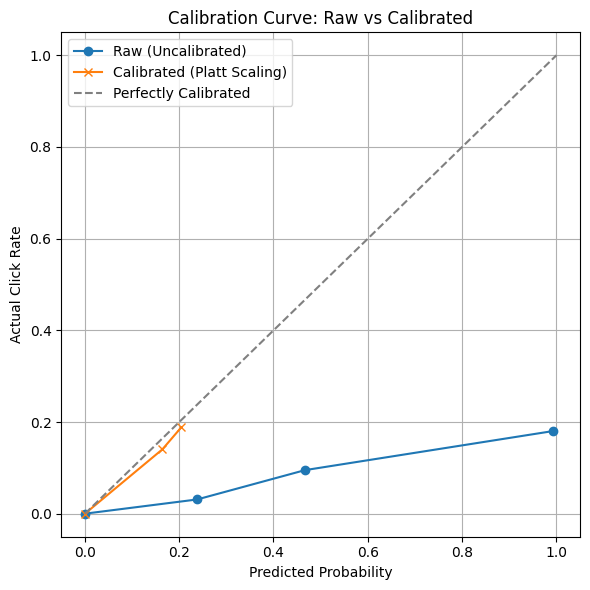

Brier Score (Uncalibrated): 0.0013
Brier Score (Calibrated): 0.0005


In [45]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute curves
prob_true_raw, prob_pred_raw = calibration_curve(y_test, raw_probs_test, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_probs, n_bins=10)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred_raw, prob_true_raw, marker='o', label='Raw (Uncalibrated)')
plt.plot(prob_pred_cal, prob_true_cal, marker='x', label='Calibrated (Platt Scaling)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Click Rate")
plt.title("Calibration Curve: Raw vs Calibrated")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("analytics/tire_calibration_curve.png")  # Save to your folder
plt.show()

from sklearn.metrics import brier_score_loss

brier_raw = brier_score_loss(y_test, raw_probs_test)
brier_cal = brier_score_loss(y_test, calibrated_probs)

print(f"Brier Score (Uncalibrated): {brier_raw:.4f}")
print(f"Brier Score (Calibrated): {brier_cal:.4f}")


AUC-ROC: 0.8685
Precision: 0.1804
Recall: 0.4118
F1 Score: 0.2509
Confusion Matrix:
TP: 70, FP: 318, TN: 322705, FN: 100
Class Distribution:
Clicked: 170, Not Clicked: 323023


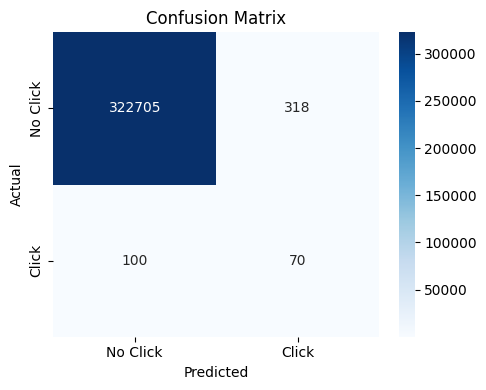

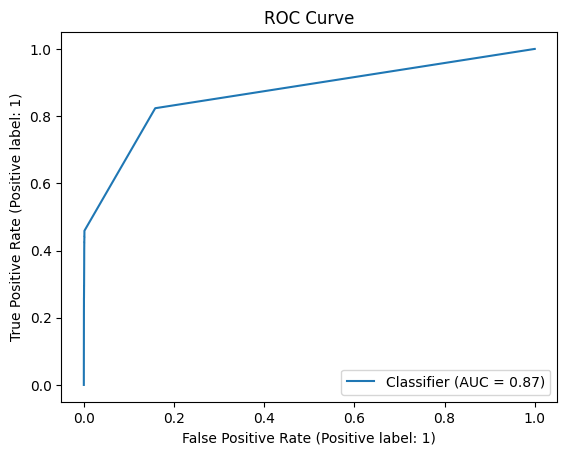

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, RocCurveDisplay
)

# === Predict probabilities and binary outcomes ===
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)

# === Compute metrics ===
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# === Class distribution ===
clicked = int(np.sum(y_test == 1))
not_clicked = int(np.sum(y_test == 0))

# === Print to console ===
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\nTP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Class Distribution:\nClicked: {clicked}, Not Clicked: {not_clicked}")

# === Plot confusion matrix ===
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Click', 'Click'], yticklabels=['No Click', 'Click'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("analytics/tire_confusion_matrix.png")
plt.show()

# === Plot ROC Curve ===
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title("ROC Curve")
plt.savefig("analytics/tire_roc_curve.png")
plt.show()

# === Prepare for JSON export ===
metrics = {
    "auc_roc": round(auc_roc, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1_score": round(f1, 4),
    "confusion_matrix": {
        "true_positive": int(tp),
        "false_positive": int(fp),
        "true_negative": int(tn),
        "false_negative": int(fn)
    },
    "class_distribution": {
        "clicked": clicked,
        "not_clicked": not_clicked
    }
}

from sklearn.metrics import roc_curve
import json

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

roc_data = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist()
}

with open("analytics/tire_roc_data.json", "w") as f:
    json.dump(roc_data, f)

# === Save to JSON ===
with open("analytics/tire_performance_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

# Testing on Personalized we get

In [47]:
import pandas as pd

# Your user profile IDs
user_profile_ids = ['10024', '10052', '10057', '10093',
                    '11379', '11680', '13496', '13678',
                    '13800', '13874']

# Multi-hot encode user profile IDs using trained mlb
user_profile_encoded = pd.DataFrame(
    mlb.transform([user_profile_ids]),
    columns=[f"User_Profile_{id_}" for id_ in mlb.classes_]
)

# Input feature values with corrected ad_slot_ratio
test_data = {
    'hour': pd.Categorical([15]),
    'day_of_the_week': pd.Categorical([2]),
    'is_weekend': pd.Categorical([0]),
    'part_of_the_day': pd.Categorical(['afternoon']),
    'ip_subnet_hash': pd.Categorical(['Other']),
    'Domain_Cat': pd.Categorical(['Other']),
    'os_family': pd.Categorical(['Mac']),
    'browser_family': pd.Categorical(['Safari']),
    'device_type': pd.Categorical(['desktop']),
    'Region_ID': pd.Categorical(['0']),
    'City_ID': pd.Categorical(['0']),
    'Ad_Exchange': pd.Categorical(['2']),
    'Ad_Slot_ID_grouped': pd.Categorical(['Other']),
    'ad_slot_visibility': pd.Categorical(['0']),
    'Ad_Slot_Format': pd.Categorical(['1']),
    'Creative_ID': pd.Categorical(['e1b0b6fb39abeb138c0b1e37c5f6d777']),

    # Numeric fields (including fixed ad_slot_ratio)
    'minute': [27.71],
    'ad_slot_width': [568.8276],
    'ad_slot_height': [195.131],
    'ad_slot_ratio': [5.203],
    'ad_slot_area': [79034.61],
    'Ad_Slot_Floor_Price': [17.428],
}

# Create test DataFrame
test_df = pd.DataFrame(test_data)

# Concatenate with multi-hot user profile encoding
final_test_df = pd.concat([test_df, user_profile_encoded], axis=1)

# Reorder to match training data columns
final_test_df = final_test_df.reindex(columns=X_train.columns, fill_value=0)

# Predict
y_pred_proba = model.predict(final_test_df)
print("🔍 Predicted click probability:", y_pred_proba[0])

🔍 Predicted click probability: 0.00048472654594982137


In [48]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.calibration import CalibratedClassifierCV

# Load the dataset
df = pd.read_csv("processed_advertiser_1458.csv")

# Define categorical columns
categorical_columns = [
    'hour', 'day_of_the_week', 'is_weekend', 'part_of_the_day',
    'ip_subnet_hash', 'Domain_Cat',
    'os_family', 'browser_family', 'device_type', 'Region_ID',
    'City_ID', 'Ad_Exchange', 'Ad_Slot_ID_grouped', 'ad_slot_visibility',
    'Ad_Slot_Format', 'Creative_ID'
]

# Preprocess User Profile IDs
df['User_Profile_IDs'] = df['User_Profile_IDs'].fillna("")
df['User_Profile_IDs'] = df['User_Profile_IDs'].apply(
    lambda x: [i.strip() for i in x.split(',') if i.strip()]
)

# Multi-hot encode User Profile IDs
mlb = MultiLabelBinarizer()
user_profile_encoded = pd.DataFrame(
    mlb.fit_transform(df['User_Profile_IDs']),
    columns=[f"User_Profile_{id_}" for id_ in mlb.classes_],
    index=df.index
)

# Convert categorical columns to 'category' dtype
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Merge encoded user profiles
df = pd.concat([df.drop('User_Profile_IDs', axis=1), user_profile_encoded], axis=1)

# Split features and labels
X = df.drop('Click', axis=1)
y = df['Click']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train LightGBM using scikit-learn API
lgbm_model = LGBMClassifier(
    objective='binary',
    n_estimators=1000,
    importance_type='gain'
)

# Fit with early stopping
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
    categorical_feature=[col for col in categorical_columns if col in X.columns],
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.896192	valid_0's binary_logloss: 0.0218686


LGBMClassifier(importance_type='gain', n_estimators=1000, objective='binary')

In [49]:
import numpy as np
# Calibrate with sigmoid (Platt scaling)
calibrated_model = CalibratedClassifierCV(
    estimator=lgbm_model,
    method='sigmoid',  # Or use 'isotonic' if you have lots of data
    cv='prefit'
)
calibrated_model.fit(X_test, y_test)

# Predict calibrated probabilities
calibrated_probs = calibrated_model.predict_proba(X_test)[:, 1]

# (Optional) Bidding logic
base_bid = 0.1
avg_ctr = y.mean()
bids = base_bid * (1 + np.log1p(calibrated_probs / avg_ctr))

# Output sample
print("Sample calibrated probabilities:", calibrated_probs[:5])
print("Sample bid prices:", bids[:5])

Sample calibrated probabilities: [0.00017176 0.00017176 0.00017176 0.00017176 0.00017176]
Sample bid prices: [0.11931579 0.11931579 0.11931579 0.11931579 0.11931579]


In [50]:
bids.max()

0.7250435112013421

In [51]:
calibrated_probs.mean()

0.0008064926311889858

In [52]:
calibrated_probs.max()

0.41694842892064926

In [53]:
bids.mean()

0.12025847013129685

In [54]:
bids.min()

0.11931349598324595

In [55]:
bids_clicked = bids[y_test == 1]

In [56]:
bids_clicked

array([0.72504351, 0.72504351, 0.72504351, 0.72504351, 0.72504351,
       0.72504351, 0.72504351, 0.72504351, 0.72504351, 0.72464457,
       0.72504351, 0.72504351, 0.11931579, 0.72504351, 0.72504351,
       0.72504351, 0.11931579, 0.72504316, 0.72504351, 0.72504351,
       0.72504351, 0.11931579, 0.72504351, 0.72504351, 0.72504351,
       0.72504351, 0.71968305, 0.11931579, 0.72504351, 0.72504351,
       0.11931579, 0.72504351, 0.72504351, 0.72504351, 0.72504351,
       0.72504351, 0.11931579, 0.11931579, 0.71968305, 0.11931579,
       0.11931579, 0.72504351, 0.72504351, 0.72504351, 0.72504351,
       0.11931579, 0.72504351, 0.72504351, 0.71968305, 0.11931579,
       0.11931579, 0.72504351, 0.72504351, 0.72504351, 0.72504351,
       0.11931579, 0.72464457, 0.11931579, 0.72504351, 0.72504351,
       0.72504351, 0.11931579, 0.72504351, 0.72504351, 0.70884504,
       0.72504351, 0.72504316, 0.72504351, 0.72504351, 0.72504351,
       0.72504351, 0.72504351, 0.72504351, 0.11931579, 0.72504

In [57]:
y_test.sum()

425

In [58]:
y_test.shape

(526979,)

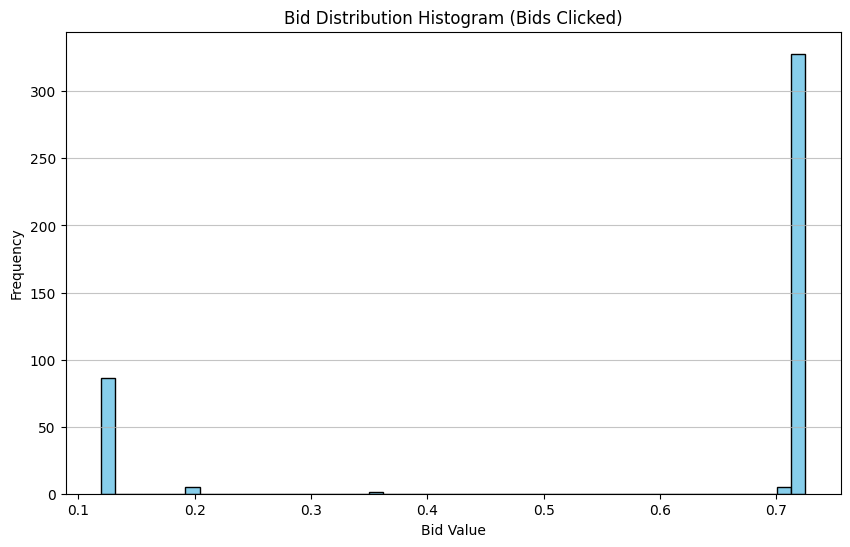

Exported histogram data to analytics/bids_clicked_histogram.json


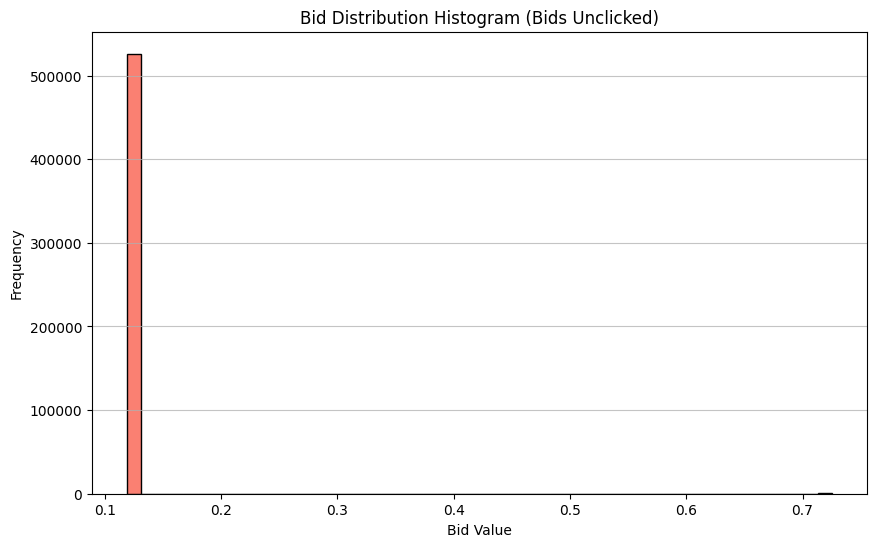

Exported histogram data to analytics/bids_unclicked_histogram.json


In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json

# Ensure analytics folder exists
os.makedirs("analytics", exist_ok=True)

# Assume bids and y_test arrays already defined
bids_clicked = bids[y_test == 1]
bids_unclicked = bids[y_test == 0]

def plot_and_export_histogram(bids_array, filename_prefix, color):
    # Compute histogram data
    counts, bin_edges = np.histogram(bids_array, bins=50)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Plot histogram
    plt.figure(figsize=(10,6))
    plt.hist(bids_array, bins=50, color=color, edgecolor='black')
    plt.title(f"Bid Distribution Histogram ({filename_prefix.replace('_', ' ').title()})")
    plt.xlabel("Bid Value")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    
    # Prepare data for JSON export
    hist_data = {
        "labels": bin_centers.tolist(),
        "counts": counts.tolist()
    }
    
    # Save to JSON
    json_path = os.path.join("analytics", f"{filename_prefix}_histogram.json")
    with open(json_path, "w") as f:
        json.dump(hist_data, f)
    
    print(f"Exported histogram data to {json_path}")

# Plot and export clicked bids histogram
plot_and_export_histogram(bids_clicked, "bids_clicked", "skyblue")

# Plot and export unclicked bids histogram
plot_and_export_histogram(bids_unclicked, "bids_unclicked", "salmon")

Max bid (unclicked): 0.7250435112013421
Min bid (unclicked): 0.11931349598324595
Mean bid (unclicked): 0.12
Median bid (unclicked): 0.1193157938949169
25th percentile (unclicked): 0.1193157938949169
75th percentile (unclicked): 0.1193157938949169


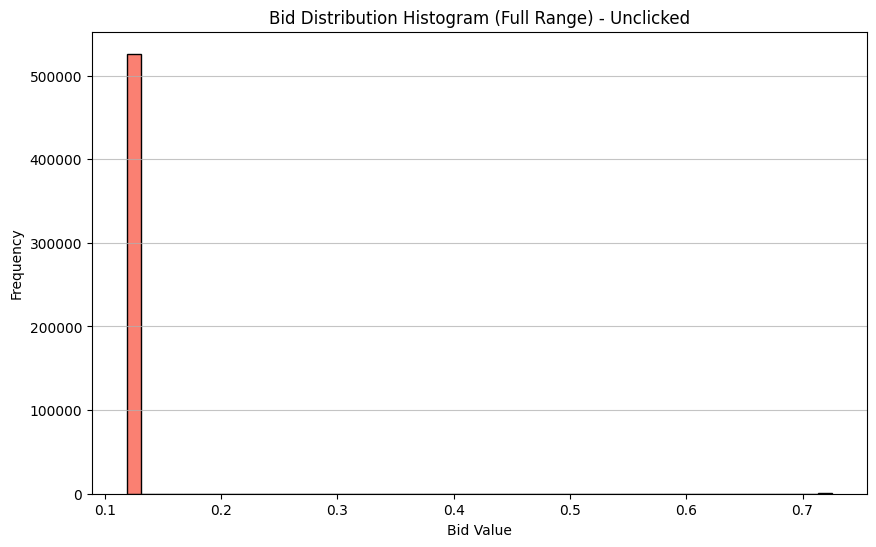

In [60]:
import numpy as np
import matplotlib.pyplot as plt

bids_unclicked = bids[y_test == 0]

# Summary statistics
max_bid = np.max(bids_unclicked)
min_bid = np.min(bids_unclicked)
mean_bid = np.mean(bids_unclicked)
median_bid = np.median(bids_unclicked)
q75 = np.percentile(bids_unclicked, 75)
q25 = np.percentile(bids_unclicked, 25)

print(f"Max bid (unclicked): {max_bid}")
print(f"Min bid (unclicked): {min_bid}")
print(f"Mean bid (unclicked): {mean_bid:.2f}")
print(f"Median bid (unclicked): {median_bid}")
print(f"25th percentile (unclicked): {q25}")
print(f"75th percentile (unclicked): {q75}")

# Plot histogram without cutoff
plt.figure(figsize=(10,6))
plt.hist(bids_unclicked, bins=50, color='salmon', edgecolor='black')  # No range limits
plt.title("Bid Distribution Histogram (Full Range) - Unclicked")
plt.xlabel("Bid Value")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()
